# Lógica Computacional 24/25

**Grupo 09**

- João Afonso Almeida Sousa (A102462)
- Rafael Cunha Costa (A102526)

Este projeto tem como objetivo gerar grafos direcionados utilizando restrições lógicas e analisar a robustez desses grafos em termos de conectividade.



# Problema A

2. Um sistema de tráfego é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .  O grafo tem de ser ligado: entre cada par de nodos <n1,n2> tem de existir um caminho n1⇝n2 e um caminho n2⇝n1.

    a. Gerar aleatoriamente o grafo com  N∈{6..10} nodos e com ramos verificando:

        i. Cada nodo tem um número aleatório de descendentes d∈{1 .. 3} cujos destinos são também gerados aleatoriamente.

        ii. Se existirem “loops” ou destinos repetidos, deve-se gerar outro grafo.

    




# Inicialização

Para resolver os problemas de satisfação de restrições, usamos o Z3py, uma biblioteca Python que cria uma interface para o Z3, um solver SMT.

Para instalar o Z3py, basta correr o seguinte comando:

In [1]:
pip install z3-solver

Note: you may need to restart the kernel to use updated packages.


Usamos também a biblioteca NetworkX para manipulação de grafos e a biblioteca Matplotlib para visualização dos grafos.

In [2]:
from z3 import *
import networkx as nx
import matplotlib.pyplot as plt
import random

## Análise das Restrições

1. **Sem loops**: 
    $$
    \forall i \in \{1, \ldots, N\}, \neg \text{edge}_{i,i}
    $$
    Nenhum nodo pode ter uma aresta para si mesmo.

2. **Vias de sentido único**: 
    $$
    \forall i, j \in \{1, \ldots, N\}, i \neq j \implies (\text{edge}_{i,j} \rightarrow \neg \text{edge}_{j,i})
    $$
    Se existe uma aresta de $(i)$ para $(j)$, não pode existir uma de $(j)$ para $(i)$.

3. **Conectividade bidirecional**: 
    $$
    \forall i, j \in \{1, \ldots, N\}, i \neq j \implies (\text{edge}_{i,j} \lor \text{edge}_{j,i})
    $$
    Deve existir um caminho de $(i)$ para $(j)$ e de $(j)$ para $(i)$.

4. **Número de descendentes**: 
    $$
    \forall i \in \{1, \ldots, N\}, 1 \leq \sum_{j=1}^{N} \text{edge}_{i,j} \leq 3
    $$
    Cada nodo deve ter entre 1 e 3 descendentes.

# Implementação

**Criação de um grafo de acordo com as restrições:**

In [3]:
def gerarGrafo(N):
    solver = Solver()

    #Preencher arestas com bools que registam a existência das arestas
    arestas = []
    for i in range(N):
        linha = []
        for j in range(N):
            variavel_aresta = Bool(f"edge_{i}_{j}")
            linha.append(variavel_aresta)
        arestas.append(linha)
    
    #Não podem haver loops (arestas de i para i)
    for i in range(N):
        solver.add(Not(arestas[i][i]))

    #Só podem existir vias de comunicação de sentido único
    for i in range(N):
        for j in range(N):
            if i != j:
                solver.add(Implies(arestas[i][j], Not(arestas[j][i])))

    #Para cada par de nodos <n1,n2>, tem de existir um caminho n1->n2 e n2->n1
    for i in range(N):
        for j in range(N):
            if i != j:
                solver.add(Or(arestas[i][j], arestas[j][i]))

    #Cada nodo tem de ter de 1 a 3 descendentes
    for i in range(N):
        descendentes = [If(arestas[i][j], 1, 0) for j in range(N)]
        solver.add(And(Sum(descendentes) >= 1, Sum(descendentes) <= 3))

    #Verificar se é satisfazível
    if solver.check() == sat:
        model = solver.model()
        
        grafo = nx.DiGraph()
        grafo.add_nodes_from(range(1, N+1))

        for i in range(N):
            for j in range(N):
                if model.evaluate(arestas[i][j]):
                    grafo.add_edge(i+1, j+1)

        return grafo
    else:
        print("Solução não encontrada!!")

# Problema B

Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.


### Análise das Restrições do Problema B

Para resolver o problema B, é necessário garantir que o grafo permaneça fortemente conectado após a remoção de um número máximo de arestas. As restrições a serem consideradas são:

1. **Conectividade Forte**:
    - O grafo deve permanecer fortemente conectado, ou seja, deve existir um caminho direcionado entre qualquer par de nodos no grafo.

2. **Remoção de Arestas**:
    - Devemos determinar o maior número de arestas que podem ser removidas sem comprometer a conectividade forte do grafo.

Para isso, a função `calcularMaxRemocoes` realiza as seguintes etapas:
- Verifica se o grafo inicial é fortemente conectado.
- Itera sobre todas as arestas do grafo, removendo uma de cada vez e verificando se o grafo ainda permanece fortemente conectado.
- Conta o número máximo de arestas que podem ser removidas mantendo a conectividade forte.

Essas restrições garantem que o grafo resultante após a remoção das arestas ainda satisfaça a condição de conectividade forte, essencial para a robustez do sistema de tráfego representado pelo grafo.


In [4]:
def calcularMaxRemocoes(grafo):
    #Verificar se o grafo está ligado
    if not nx.is_strongly_connected(grafo):
        return 0

    #Lista original de arestas
    arestas = list(grafo.edges())
    nMaxRemocoes = 0
    
    #Testar remoções de arestas
    grafoCopia = grafo.copy()
    for i in range(len(arestas)):
        #Remover uma aresta
        grafoCopia.remove_edge(*arestas[i])
        
        #Verificar se o grafo ainda está ligado
        if nx.is_strongly_connected(grafoCopia):
            nMaxRemocoes += 1
        else:
            #Se o grafo deixar de ser ligado, adicionar aresta denovo
            grafoCopia.add_edge(*arestas[i])
    return (nMaxRemocoes,grafoCopia)

**Geração aleatória do grafo:**

In [7]:
#Gerar um grafo com um número aleatório de vértices entre 6 e 10
N = random.randint(6, 10)
grafo = gerarGrafo(N)

**Impressão do grafo e do seu subgrafo com o número de arestas removidas:** 

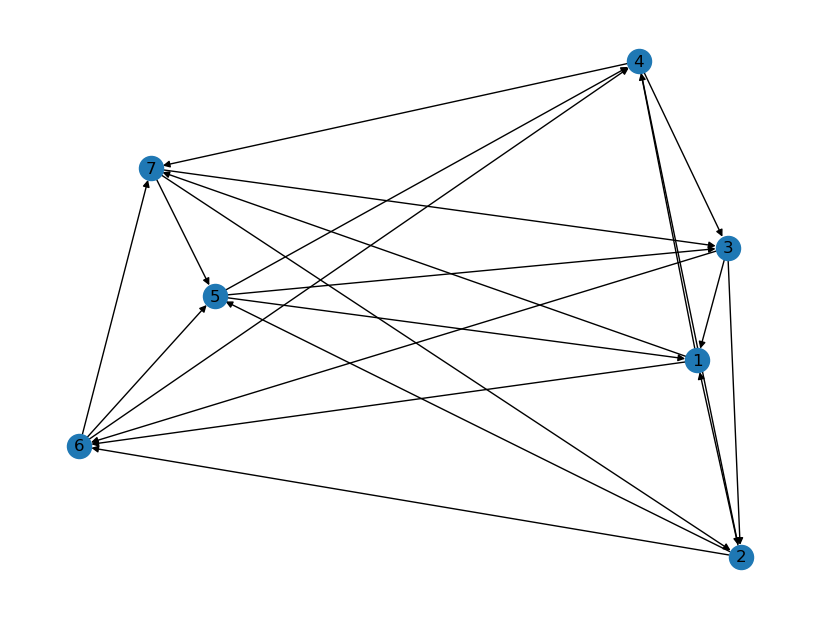

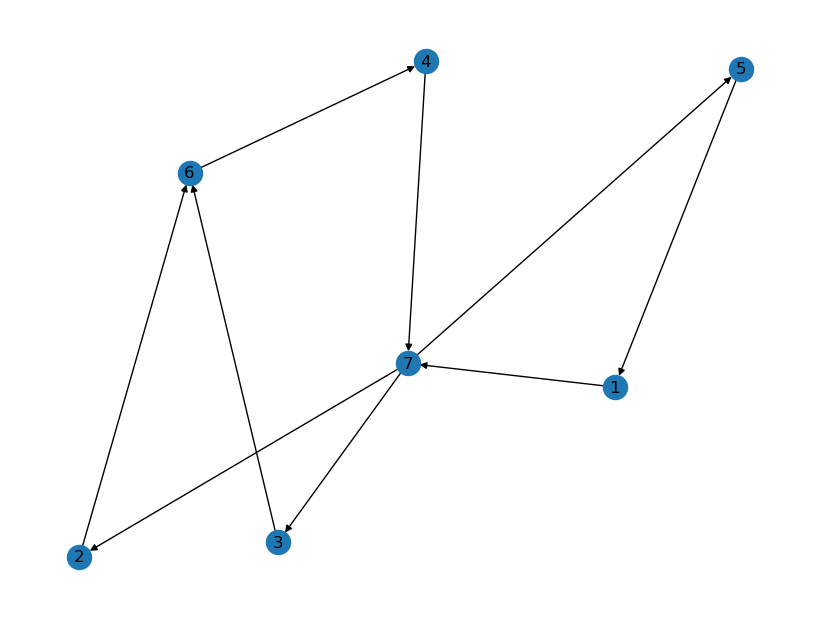

Maior número de vias que podem ser removidas mantendo o grafo ligado: 12


In [8]:
#Printar o grafo
plt.figure(figsize=(8, 6))
nx.draw(grafo, with_labels=True)
plt.show()
(nMaxRemocoes,grafoCopia) = calcularMaxRemocoes(grafo)
plt.figure(figsize=(8, 6))
nx.draw(grafoCopia, with_labels=True)
plt.show()
print(f"Maior número de vias que podem ser removidas mantendo o grafo ligado: {nMaxRemocoes}")